In [52]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [53]:
gmsh.initialize()

# gmsh.open('IITM_Map_final')
gmsh.open('IITM_Map_sf_10.msh')

# Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

# Total number of nodes is the length of nodeTags
total_nodes = len(nodeTags)
coordinates = coordinates.reshape((-1, 3))

sorted_indices = np.argsort(nodeTags)
sorted_coordinates = coordinates[sorted_indices]


# coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
dim = 2 #for triangles
tag = -1 #get all
ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
node_tags = node_tags.reshape((-1,3))

triangle = []
for tag, nodes in zip(ele_tags, node_tags):
    x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
    x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
    x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
    triangle.append([x1,y1,x2,y2,x3,y3])
    
triangle = np.array(triangle)

gmsh.finalize()

In [54]:
nodeTags

array([    1,     2,     3, ..., 15464, 15465, 15466], dtype=uint64)

In [55]:
np.argsort(nodeTags)

array([    0,     1,     2, ..., 15463, 15464, 15465], dtype=int64)

In [56]:
coordinates.shape

(15466, 3)

In [57]:
sorted_coordinates

array([[ 742.7       , 1103.3       ,    0.        ],
       [ 730.9       , 1041.3       ,    0.        ],
       [ 630.7       ,  787.6       ,    0.        ],
       ...,
       [ 774.06039898,  591.59466129,    0.        ],
       [ 780.50441087, 1091.41186055,    0.        ],
       [ 844.67744587, 1057.38328005,    0.        ]])

In [58]:
total_nodes

15466

In [59]:
ele_tags.shape

(30928,)

In [60]:
node_tags.shape

(30928, 3)

In [61]:
triangle.shape

(30928, 6)

In [62]:
triangle

array([[ 651.63214726,  479.88637919,  648.92156884,  483.49369314,
         645.44672311,  478.2266117 ],
       [ 306.70469176,  386.32549215,  298.86574906,  391.39497611,
         298.70998856,  382.93938748],
       [ 516.28991634,  471.4800131 ,  514.49000159,  469.64198267,
         516.4581975 ,  468.71119572],
       ...,
       [ 864.9       , 1082.6       ,  860.67821362, 1082.01441535,
         862.84      , 1073.38      ],
       [ 719.5       , 1112.9       ,  724.94      , 1112.42      ,
         725.2       , 1115.5       ],
       [ 724.4       , 1109.5       ,  724.94      , 1112.42      ,
         719.5       , 1112.9       ]])

In [63]:
def solution(x,y):
    sigma = 4.8/2.7
    sol = (1/(2*np.pi*sigma**2))*np.exp(-1*((x - 472)**2 + (y - 486.7 )**2)/(2*sigma**2))
    return sol

In [64]:
def heron(x1,y1,x2,y2,x3,y3):
    area = 0.5*(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    if area >= 0:
        return area
    else:
        return -1*area

In [65]:
def numerical_intergation(func,x1,y1,x2,y2,x3,y3):
    pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
    weights = [1/6, 1/6, 1/6]
    
    integral = 0
    
    for i in range(len(weights)):
        integral+= func(pts[i][0],pts[i][1],x1,y1,x2,y2,x3,y3)*weights[i]
        
    return integral

In [66]:
def triangle_jacobian(x1,y1,x2,y2,x3,y3):
    dx_deps = -x1 + x2
    dx_deta = -x1 + x3
    dy_deps = -y1 + y2
    dy_deta = -y1 + y3
    
    jacobian = dx_deps*dy_deta - dx_deta*dy_deps
    return jacobian

In [67]:
node_tags

array([[ 6357, 10278,   548],
       [ 7117,  9392,  2825],
       [ 8867, 10209,  9002],
       ...,
       [   69, 14908,   359],
       [   85, 14849,    84],
       [   86, 14849,    85]], dtype=uint64)

In [68]:
def construct_A(total_nodes, node_tags, triangle):
    
    n = total_nodes
    A = np.zeros((n,n))
    
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        x1,y1,x2,y2,x3,y3 = triangle[i]
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        
        a = np.zeros((3,3))
        for j in range(len(weights)):
            N = np.array([1-pts[j][0] - pts[j][1], pts[j][0], pts[j][1]])
            N = N.reshape((3, 1))
            a += (N @ N.T)*jac*weights[j]
        
        for k in range(3):
            for l in range(3):
                A[int(nodes[k]-1), int(nodes[l]-1)] += a[k][l]
                    
        # A_2d[0,0] += (numerical_intergation(neg_func, xi, xi_1)*jac)
        # A_2d[0,1] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,0] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,1] += (numerical_intergation(pos_func, xi, xi_1)*jac)
        
        # A[i:i+2, i:i+2] += A_2d
        
    return A

In [69]:
def construct_f(total_nodes, node_tags, triangle):
    
    n = total_nodes
    f = np.zeros((n,1))
    
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        x1,y1,x2,y2,x3,y3 = triangle[i]
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        
        f_2d = np.zeros((3,1))
        for j in range(len(weights)):
            x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            N = solution(x,y)*np.array([1-pts[j][0] - pts[j][1], pts[j][0], pts[j][1]])
            N = N.reshape((3, 1))
            f_2d += (N)*jac*weights[j]
        
        for k in range(3):
                f[int(nodes[k]-1)] += f_2d[k]
                    
        # A_2d[0,0] += (numerical_intergation(neg_func, xi, xi_1)*jac)
        # A_2d[0,1] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,0] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,1] += (numerical_intergation(pos_func, xi, xi_1)*jac)
        
        # A[i:i+2, i:i+2] += A_2d
        
    return f

In [70]:
def construct_c(A,f):
    A_inv = np.linalg.inv(A)
    C = np.matmul(A_inv, f)
    return C

In [71]:
def cal_error(node_tags, triangle, C):
    error = 0
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        x1,y1,x2,y2,x3,y3 = triangle[i]
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        
        C_0 = C[int(nodes[0]-1)]
        C_1 = C[int(nodes[1]-1)]
        C_2 = C[int(nodes[2]-1)]
        
        for j in range(len(weights)):
            x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            error += ((solution(x,y) - C_0*(1-pts[j][0] - pts[j][1]) - C_1*pts[j][0] - C_2*pts[j][1])**2)*weights[j]*jac
            
    return (error)**0.5

In [72]:
A = construct_A(total_nodes, node_tags, triangle)
f = construct_f(total_nodes, node_tags, triangle)
C = construct_c(A,f)
error = cal_error(node_tags, triangle, C)
error    

array([0.08620864])

In [73]:
C

array([[ 3.36709708e-56],
       [ 4.79361753e-51],
       [ 1.15178404e-29],
       ...,
       [-1.31315365e-29],
       [-2.71421435e-56],
       [-1.02619760e-55]])

In [74]:
A.shape

(15466, 15466)

In [75]:
f.shape

(15466, 1)

In [76]:
A

array([[35.25689681,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 37.53498276,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 42.31482371, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 20.70731539,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        21.24024375,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 16.20096729]])

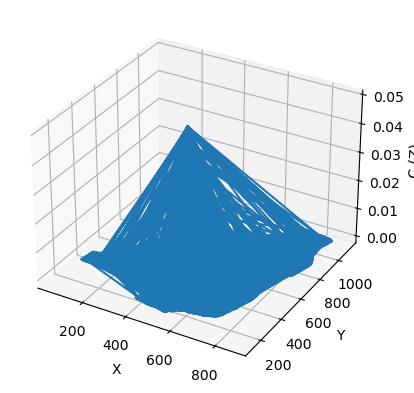

In [77]:
# Example: sorted_coordinates is an Nx3 array and C is the scalar field or z-values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create 3D plot
ax.plot(sorted_coordinates[:, 0], sorted_coordinates[:, 1], C[:,0])

# Optionally label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('C (Z)')

plt.show()

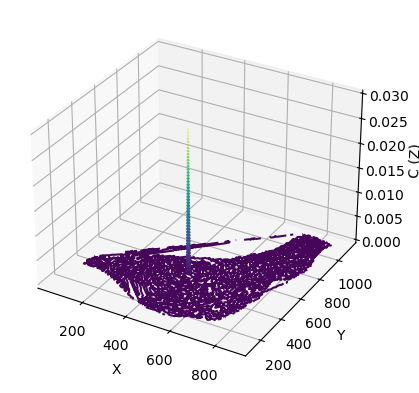

In [78]:
from scipy.interpolate import griddata
# Extract x, y coordinates
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
z = C[:, 0]  # Scalar field (C) representing Z values

# Create a 2D grid of x, y values
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(xi, yi)

# Interpolate Z values onto the grid
Z = griddata((x, y), z, (X, Y), method='linear')

# Create a 3D contour plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D contours
ax.contour3D(X, Y, Z, 50, cmap='viridis')

# Optionally label the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('C (Z)')

plt.show()

Interpolated Solution

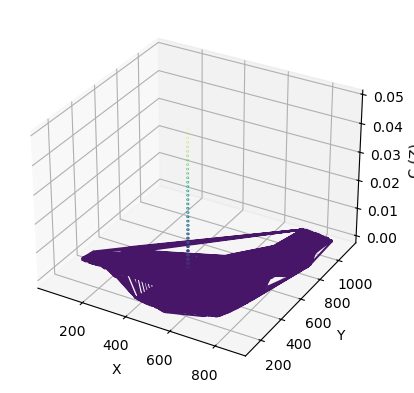

In [79]:
# Assume sorted_coordinates is an Nx3 array and C is a scalar field (Z values)

# Extract x, y coordinates
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
z = C[:, 0]  # Scalar field (C) representing Z values

# Create a 3D plot for contouring scattered data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D contours using tricontour
contour = ax.tricontour(x, y, z, levels=50, cmap='viridis')

# Optionally label the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('C (Z)')

plt.show()

True Solution

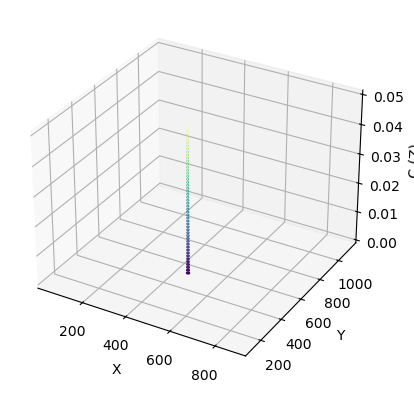

In [80]:
# Assume sorted_coordinates is an Nx3 array and C is a scalar field (Z values)

# Extract x, y coordinates
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
z = solution(x,y)  # Scalar field (C) representing Z values

# Create a 3D plot for contouring scattered data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D contours using tricontour
contour = ax.tricontour(x, y, z, levels=50, cmap='viridis')

# Optionally label the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('C (Z)')

plt.show()

Error

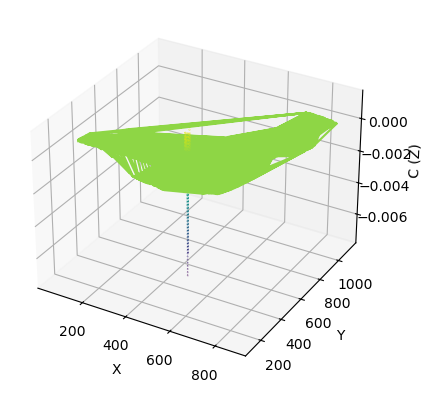

In [81]:
# Assume sorted_coordinates is an Nx3 array and C is a scalar field (Z values)

# Extract x, y coordinates
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
z = solution(x,y) - C[:,0]  # Scalar field (C) representing Z values

# Create a 3D plot for contouring scattered data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D contours using tricontour
contour = ax.tricontour(x, y, z, levels=50, cmap='viridis')

# Optionally label the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('C (Z)')

plt.show()

In [82]:
num = [10, 15, 20, 25]
error_array = []
for i in range(len(num)):
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    # gmsh.open(f'IITM_Map_lc_{num[i]}.msh')
    gmsh.open(f'IITM_Map_sf_{num[i]}.msh')


    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))

    triangle = []
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        
    triangle = np.array(triangle)

    gmsh.finalize()


    A = construct_A(total_nodes, node_tags, triangle)
    f = construct_f(total_nodes, node_tags, triangle)
    C = construct_c(A,f)
    error = cal_error(node_tags, triangle, C)
    error_array.append(error)
    print(error)    

[0.08620864]
[0.09790965]
[0.28397614]
[0.31506469]


In [83]:
num = [10, 15, 20, 25]
h_array = []
for i in range(len(num)):
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    # gmsh.open(f'IITM_Map_lc_{num[i]}.msh')
    gmsh.open(f'IITM_Map_sf_{num[i]}.msh')
    
        # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))

    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        area+= heron(x1,y1,x2,y2,x3,y3)
        
    area = area/node_tags.shape[0]
    
    h = area**0.5
    h_array.append(h)       

In [84]:
h_array

[4.67483784725051, 6.650035370326245, 8.862205142666468, 9.85740687936127]

In [85]:
np.log(error_array), np.log(h_array[0:6])

(array([[-2.45098489],
        [-2.32371016],
        [-1.25886505],
        [-1.15497729]]),
 array([1.54219448, 1.89462217, 2.18179562, 2.28822314]))

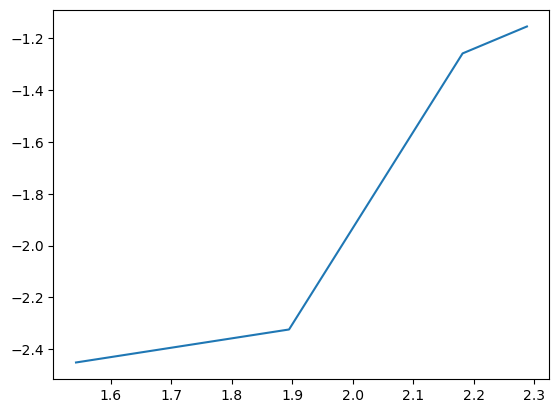

In [86]:
plt.plot(np.log(h_array), np.log(error_array))

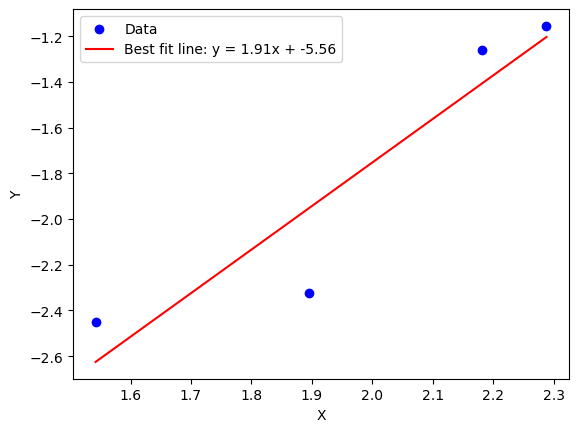

In [87]:
x = np.log(h_array)
y = np.log(error_array)
slope, intercept = np.polyfit(x, y, 1)
# Convert slope and intercept to scalars
slope = slope.item() if isinstance(slope, np.ndarray) else slope
intercept = intercept.item() if isinstance(intercept, np.ndarray) else intercept


# Create the best fit line
y_fit = slope * x + intercept

# Plot the original data points
plt.scatter(x, y, color='blue', label='Data')

# Plot the best-fit line
plt.plot(x, y_fit, color='red', label=f'Best fit line: y = {slope:.2f}x + {intercept:.2f}')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Show the plot
plt.show()

In [88]:
num = [10, 15, 20, 25]
num_elements = []
num_nodes = []
for i in range(len(num)):
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    # gmsh.open(f'IITM_Map_lc_{num[i]}.msh')
    gmsh.open(f'IITM_Map_sf_{num[i]}.msh')
    
        # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]
    
     # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    
    num_elements.append(node_tags.shape[0])
    num_nodes.append(total_nodes)

In [89]:
num_elements

[30928, 15284, 8606, 6956]

In [90]:
num_nodes

[15466, 7644, 4305, 3480]